<a href="https://colab.research.google.com/github/rxkt/mask-detector-strict/blob/master/mask_detection_strict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Uncomment the following if running in Google Colab
# You need to have the data folder in your own Google Drive for Colab to read the images.
# You can obtain the data folder from the Google Drive link below.

# from google.colab import drive
# drive.mount('/content/drive')
# import os
# os.chdir("/content/drive/")

## Abstract  
In this notebook we will use a CNN to classify images of people with and without masks, and then check that masks fully cover the nose and mouth to ensure proper mask usage.

## Dependencies  
The following libraries are required to run this notebook:  
- matplotlib  
- numpy  
- tensorflow, keras  
- opencv-python  
- dlib  
- imutils  


## Required libraries, pre-trained models, datasets  

The following can be obtained from the github repo where this file is located at:  
- Haarcascades
- Facial Landmarks data (for dlib)  

The dataset can be obtained from Google Drive:
- https://drive.google.com/drive/folders/1FAV5pjW3CDyicxBFpsEBnFqValLbXm5R?usp=sharing 

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use("ggplot")

import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator


## Creating the model  
First we access all the images that we will need for the CNN model.  

In [22]:
base_dir = './data/Cropped Dataset/'
# uncomment the following line to use non-pre-processed data
# base_dir = './data/New Masks Dataset/'
train_dir = base_dir + 'Train/'
val_dir = base_dir + 'Validation/'
test_dir = base_dir + 'Test/'
batch_size = 32

data_gen_args_base = dict(
    rescale = 1./255,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    vertical_flip = False
)

# training data
train_data_generator = ImageDataGenerator(**data_gen_args_base)
train_set = train_data_generator.flow_from_directory(directory=train_dir,
                                                        target_size=(128, 128),
                                                        batch_size=batch_size,
                                                        class_mode='binary')

# validation data
val_data_generator = ImageDataGenerator(**data_gen_args_base)
val_set = val_data_generator.flow_from_directory(directory=val_dir,
                                                        target_size=(128, 128),
                                                        batch_size=batch_size,
                                                        class_mode='binary')

# test data
test_data_generator = ImageDataGenerator(**data_gen_args_base)
test_set = test_data_generator.flow_from_directory(directory=test_dir,
                                                    target_size=(128, 128),
                                                    batch_size=batch_size,
                                                    class_mode='binary')


Found 1830 images belonging to 2 classes.
Found 1098 images belonging to 2 classes.
Found 659 images belonging to 2 classes.


We create functions to plot images and check if we properly read the image files.

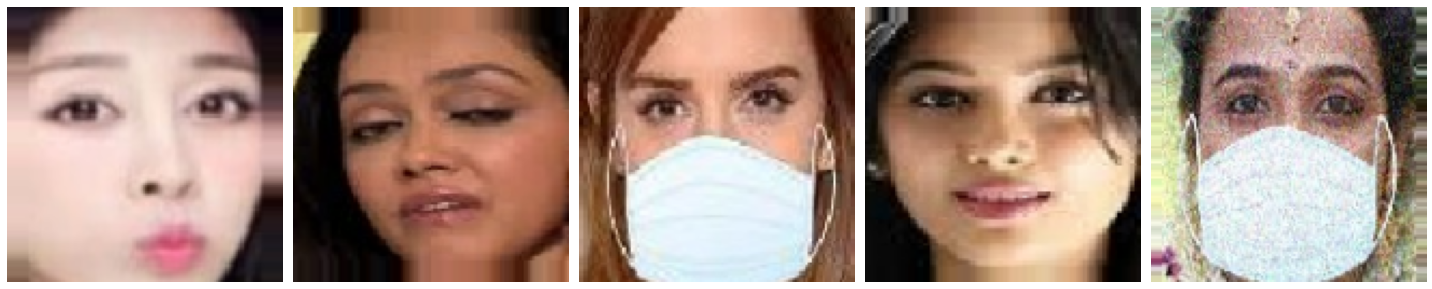

In [23]:
def plotImage(img):
    fig, ax = plt.subplots(1, 1, figsize=(5,5))
    ax.imshow(img)
    ax.axis('off')
    plt.show()
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

sample_training_images, _ = next(train_set)
plotImages(sample_training_images[:5])

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Conv2D, Flatten, MaxPool2D, Dense, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

## CNN topology
This CNN uses a bunch of convolutional layers and max pooling layers.  
Dense and dropout layers were used after flattening to reduce overfitting.  

In [25]:
INPUT_SHAPE = train_set.image_shape

cnn = Sequential()
cnn.add(Conv2D(filters=64,kernel_size=3,strides=1,activation="relu",input_shape=INPUT_SHAPE))
cnn.add(Conv2D(filters=64,kernel_size=3,strides=1,activation="relu"))
cnn.add(MaxPool2D(pool_size=(2,2),strides=(2,2),padding="same"))
cnn.add(Conv2D(filters=128,kernel_size=3,strides=1,activation="relu"))
cnn.add(Conv2D(filters=128,kernel_size=3,strides=1,activation="relu"))
cnn.add(MaxPool2D(pool_size=(2,2),strides=(2,2),padding="same"))
cnn.add(Conv2D(filters=256,kernel_size=3,strides=1,activation="relu"))
cnn.add(MaxPool2D(pool_size=(2,2),strides=(2,2),padding="same"))
cnn.add(Conv2D(filters=512,kernel_size=3,strides=1,activation="relu"))
cnn.add(MaxPool2D(pool_size=(2,2),strides=(2,2),padding="same"))
cnn.add(Flatten())
cnn.add(Dense(units=512,activation="relu"))
cnn.add(Dropout(0.5))
cnn.add(Dense(units=1024,activation="relu"))
cnn.add(Dropout(0.5))
cnn.add(Dense(units=1,activation="sigmoid"))
cnn.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])

In [26]:
early_stop = EarlyStopping(monitor="val_loss",patience=4,mode="min") #Ensure the model doesn't overfit

In [27]:
history = cnn.fit(x=train_set, batch_size=batch_size, epochs=20, callbacks=early_stop, validation_data=val_set)

Epoch 1/20
58/58 [==============================] - 84s 1s/step - loss: 0.2917 - accuracy: 0.9016 - val_loss: 0.2694 - val_accuracy: 0.9608
Epoch 2/20
58/58 [==============================] - 84s 1s/step - loss: 0.0843 - accuracy: 0.9847 - val_loss: 0.1802 - val_accuracy: 0.9690
Epoch 3/20
58/58 [==============================] - 88s 2s/step - loss: 0.1308 - accuracy: 0.9732 - val_loss: 0.1293 - val_accuracy: 0.9709
Epoch 4/20
58/58 [==============================] - 89s 2s/step - loss: 0.1158 - accuracy: 0.9803 - val_loss: 0.1018 - val_accuracy: 0.9781
Epoch 5/20
58/58 [==============================] - 86s 1s/step - loss: 0.0843 - accuracy: 0.9825 - val_loss: 0.1926 - val_accuracy: 0.9763
Epoch 6/20
58/58 [==============================] - 85s 1s/step - loss: 0.1275 - accuracy: 0.9645 - val_loss: 0.2350 - val_accuracy: 0.9645
Epoch 7/20
58/58 [==============================] - 86s 1s/step - loss: 0.0997 - accuracy: 0.9842 - val_loss: 0.1250 - val_accuracy: 0.9654
Epoch 8/20
58/58 [==

## Data visualization  
The following show the training and validation loss/accuracies to show that we are hopefully not overfitting the model.  

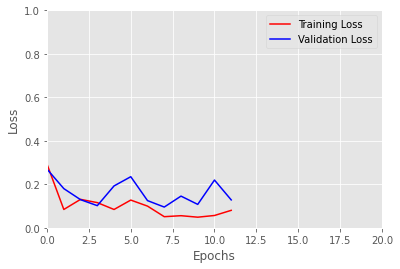

In [28]:
plt.xlim(0, 20)
plt.ylim(0,1)

plt.plot(history.history['loss'], 'r', label='Training Loss')
plt.plot(history.history['val_loss'], 'b', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

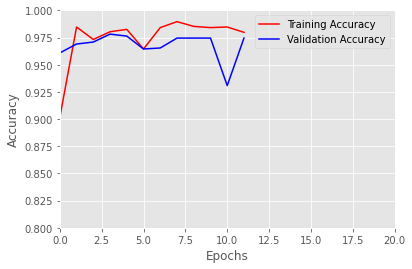

In [29]:
plt.xlim(0, 20)
plt.ylim(0.8,1)

plt.plot(history.history['accuracy'], 'r', label='Training Accuracy')
plt.plot(history.history['val_accuracy'], 'b', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [30]:
result = cnn.evaluate(test_set)
dict(zip(cnn.metrics_names, result))

21/21 [==============================] - 5s 225ms/step - loss: 0.3084 - accuracy: 0.9469


{'loss': 0.30835413932800293, 'accuracy': 0.9468892216682434}

## After CNN Model  
The following function loads the pre-trained facial landmarks detector for dlib in order to judge an image for mouth/nose detection.  
Haarcascades for noses/mouths were not used as they were too inaccurate.  

In [31]:
import cv2
import random
import os, os.path
import dlib 
import imutils
from imutils import face_utils

# initialize dlib's face detector (HOG-based) and then create
# the facial landmark predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('./shape_predictor_68_face_landmarks.dat')

# function to use dlib to detect an almost full face
def apply_dlib(img):
	gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
	# detect faces in the grayscale image
	rects = detector(gray, 1)
	# loop over the face detections
	if len(rects) == 0:
		print('No nose/mouth detected')
	else: 
		print('Nose or mouth detected!!! Improper use of a mask!!!')
	for (i, rect) in enumerate(rects):
		# determine the facial landmarks for the face region, then
		# convert the facial landmark (x, y)-coordinates to a NumPy
		# array
		shape = predictor(gray, rect)
		shape = face_utils.shape_to_np(shape)
		# convert dlib's rectangle to a OpenCV-style bounding box
		# [i.e., (x, y, w, h)], then draw the face bounding box
		(x, y, w, h) = face_utils.rect_to_bb(rect)
		cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
		# show the face number
		cv2.putText(img, "Face #{}".format(i + 1), (x - 10, y - 10),
			cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
		# loop over the (x, y)-coordinates for the facial landmarks
		# and draw them on the img
		for (x, y) in shape:
			cv2.circle(img, (x, y), 1, (0, 0, 255), -1)
	# show the output img with the face detections + facial landmarks
	plotImage(img)


The following is a function to evaluate images using the trained CNN model.

In [32]:
from keras.preprocessing import image
def evaluate_image(img):
    # rescale for CNN
    img = cv2.resize(img, (128,128), interpolation = cv2.INTER_AREA)
    img_tensor = image.img_to_array(img)
    img_tensor = np.expand_dims(img_tensor, axis=0)
    img_tensor /= 255.
    results = cnn.predict(img_tensor)
    return results[0][0]

## Applying everything for strict mask detection
For the dataset that contains improper mask usage, the following is applied:  
- Use CNN function ```evaluate_image``` to determine if mask or no mask
- If mask exists, use the mouth/nose detection function ```apply_dlib``` to determine if the mask is properly worn.

Wearing a mask, but check if it is improper: 
No nose/mouth detected


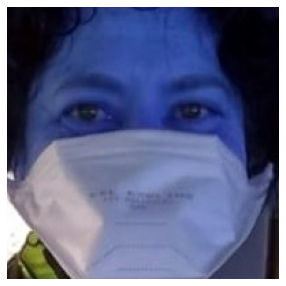

Wearing a mask, but check if it is improper: 
No nose/mouth detected


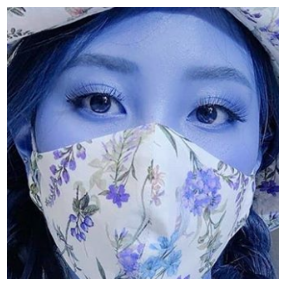

Wearing a mask, but check if it is improper: 
No nose/mouth detected


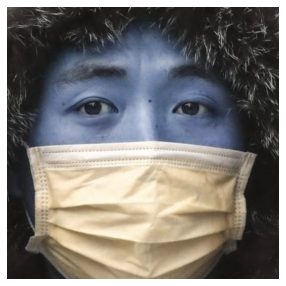

Wearing a mask, but check if it is improper: 
Nose or mouth detected!!! Improper use of a mask!!!


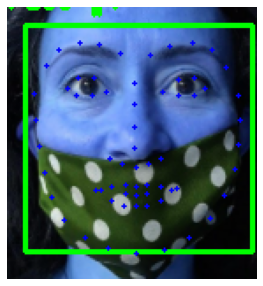

Wearing a mask, but check if it is improper: 
No nose/mouth detected


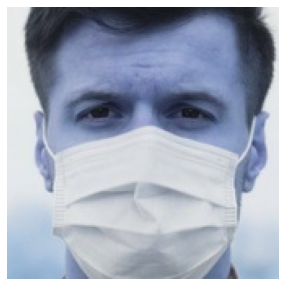

Wearing a mask, but check if it is improper: 
Nose or mouth detected!!! Improper use of a mask!!!


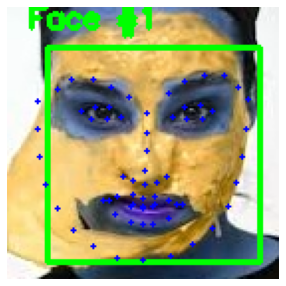

In [33]:
# apply_dlib(image)
DIR = './data/Improper Dataset/'
imageFiles = os.listdir(DIR)
for imageFile in imageFiles:
	img = cv2.imread(DIR + imageFile)
	accuracy = evaluate_image(img)
	if accuracy > 0.5:
		print('Wearing a mask, but check if it is improper: ')
		apply_dlib(img)
	else:
		# Not wearing mask; skip
		# print('Not wearing a mask, whatever.')
		pass
	
	